In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch 
import os 
import pandas as pd

In [3]:
torch.cuda.is_available()

True

In [4]:
img_path = 'public_tests/00_test_img_input/train/images/'
labels_path = 'public_tests/00_test_img_input/train/gt.csv'

In [5]:
imgs = os.listdir(img_path)

In [15]:
def labels_loader(path):
    result = {}
    data = pd.read_csv(path)
    for i in range(len(data)):
        row = data.loc[i]
        name = row['filename']
        values = row[data.columns[1:]].values
        result[name] = values
    return result

In [16]:
loaded_labels = labels_loader(labels_path)

In [17]:
print(loaded_labels)

{'00000.jpg': array([51, 51, 127, 60, 169, 65, 203, 52, 68, 77, 85, 75, 110, 82, 160,
       87, 171, 79, 193, 84, 156, 144, 92, 174, 140, 180, 168, 179],
      dtype=object), '00001.jpg': array([21, 20, 36, 18, 57, 19, 80, 25, 23, 27, 34, 26, 40, 28, 59, 30, 68,
       30, 78, 33, 43, 46, 31, 61, 45, 66, 60, 65], dtype=object), '00002.jpg': array([23, 116, 39, 83, 47, 57, 56, 19, 36, 115, 40, 96, 47, 87, 59, 60,
       59, 41, 62, 31, 91, 86, 106, 122, 115, 100, 121, 81], dtype=object), '00003.jpg': array([29, 18, 63, 25, 84, 32, 105, 34, 38, 31, 48, 34, 59, 39, 79, 44,
       85, 43, 95, 45, 72, 71, 46, 83, 63, 87, 75, 89], dtype=object), '00004.jpg': array([31, 53, 76, 44, 107, 38, 136, 33, 40, 67, 52, 62, 73, 64, 104, 58,
       115, 50, 129, 49, 111, 105, 72, 137, 106, 132, 126, 121],
      dtype=object), '00005.jpg': array([37, 37, 68, 38, 101, 40, 152, 36, 47, 53, 63, 52, 76, 58, 107, 61,
       123, 54, 136, 56, 81, 100, 68, 117, 88, 122, 115, 119],
      dtype=object), '00006.

In [7]:
labels_df = pd.read_csv(labels_path)

In [8]:
labels_df.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,00000.jpg,51,51,127,60,169,65,203,52,68,...,193,84,156,144,92,174,140,180,168,179
1,00001.jpg,21,20,36,18,57,19,80,25,23,...,78,33,43,46,31,61,45,66,60,65
2,00002.jpg,23,116,39,83,47,57,56,19,36,...,62,31,91,86,106,122,115,100,121,81
3,00003.jpg,29,18,63,25,84,32,105,34,38,...,95,45,72,71,46,83,63,87,75,89
4,00004.jpg,31,53,76,44,107,38,136,33,40,...,129,49,111,105,72,137,106,132,126,121


In [9]:
def extract_data():
    items = []
    print(len(imgs))
    for i in range(len(imgs)):
        # img = imgs[i]
        labels = labels_df.loc[labels_df['filename'] == imgs[i]][labels_df.columns[1:]].values
        labels = torch.from_numpy(labels)
        items.append((os.path.join(img_path, imgs[i]), labels[0]))
        # print(items[:5])

    # items = []
    # for i in range(labels_df.shape[0]):
    #     columns = labels_df.columns
    #     filename = labels_df[columns[0]][i]
    #     labels = labels_df[labels_df.columns[2:]].values
    #     items.append((os.path.join(img_path, filename), labels[0]))

    y = labels_df.loc[labels_df['filename'] == imgs[0]][labels_df.columns[1:]]
    return items

In [10]:
new_df = pd.DataFrame(columns=labels_df.columns)
new_df

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14


In [11]:
new_df.loc[len(new_df)] = labels_df.loc[0]
new_df

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,00000.jpg,51,51,127,60,169,65,203,52,68,...,193,84,156,144,92,174,140,180,168,179


In [12]:
# pd.concat([pd.DataFrame(labels_df.loc[0].values), new_df.loc[:]])#.reset_index(drop=True)

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
import detection

In [14]:
def vizualize(img, keypoints, transpose = True, to_torch = False):
    if to_torch:
        img = torch.from_numpy(img)
    if transpose:
        img = img.permute(1, 2, 0)
    plt.imshow(img.int())
    for i in range(0, len(keypoints)-1, 2):
        x = keypoints[i]
        y = keypoints[i+1]
        plt.plot(x,y, 'og', markersize=6)
    plt.show()

In [15]:
test_imgs_dir = 'public_tests/splitted/test/images/'
test_gt_path = 'public_tests/splitted/test/gt.csv'

In [16]:
facesPointsDataset = detection.FacesPointsDataset(imgs_path=test_imgs_dir, labels_path=test_gt_path, mode='val')

In [17]:
# model = detection.FacesPointsDetector()
# device = torch.device('cpu')
# model.load_state_dict(torch.load('lightning_logs/version_17/checkpoints/epoch=15-step=4800.ckpt', map_location=device))

In [18]:
chkpt_path =  'lightning_logs/version_25/checkpoints/epoch=7-step=2408.ckpt' #'lightning_logs/version_24/checkpoints/epoch=7-step=2408.ckpt' # 'lightning_logs/version_20/checkpoints/epoch=7-step=2408.ckpt' #lightning_logs/version_17/checkpoints/epoch=15-step=4800.ckpt'

In [19]:
# module =  detection.FacesPointsTrainingModule.load_from_checkpoint(chkpt_path, map_location='cpu')

In [20]:
img, label = facesPointsDataset[3]

In [21]:
# module.eval()

In [23]:
# module.to('cpu')
# predict = module(img[None,:]).detach()[0]

In [24]:
# print(predict)
# print(label)

In [25]:
# vizualize(img, predict)
# vizualize(img, label)

In [26]:
# import shutil

In [27]:
# permutation = np.random.permutation(6000)
# permutation

In [28]:
def train_valid_split(imgs_path, fraction, new_test_path, new_train_path, gt_train_path, gt_test_path, permutation = None):
    imgs = os.listdir(imgs_path)
    labels_df = pd.read_csv(labels_path)
    
    test_df = pd.DataFrame(columns=labels_df.columns)
    train_df = pd.DataFrame(columns=labels_df.columns)

    imgs_count = len(imgs)

    if permutation is None:
        permutation = np.random.permutation(imgs_count)
        print(permutation)

    train_items = []
    test_items = []
    for i in range(imgs_count):
        img_idx = permutation[i]
        labels = labels_df.loc[img_idx]
        assert(labels['filename'] == imgs[img_idx])
        # print(labels.columns)
        # print(labels_df.columns)
        img_path = os.path.join(imgs_path, imgs[img_idx])
        if i <= fraction*imgs_count:
            # train_df.append(labels)
            # train_df = pd.concat([train_df, pd.DataFrame(labels.values)], ignore_index=True)
            # train_df.loc[len(train_df)] = labels
            train_df.loc[len(train_df)] = labels #labels_df.loc[0]
            shutil.copy(img_path, new_train_path)
        else:
            test_df.loc[len(test_df)] = labels #test_df = pd.concat([test_df, pd.DataFrame(labels.values)], ignore_index=True)
            shutil.copy(img_path, new_test_path)
        
    test_df.to_csv(os.path.join(gt_test_path, 'gt_test.csv'), index=False)
    train_df.to_csv(os.path.join(gt_train_path, 'gt_train.csv'), index=False)
        

In [ ]:
# train_valid_split(img_path, fraction=0.8, new_test_path='public_tests/splitted/test/',
#  new_train_path='public_tests/splitted/train/', gt_test_path='public_tests/splitted/', gt_train_path='public_tests/splitted/', permutation = permutation)

In [ ]:
items = extract_data()

In [29]:
import albumentations as A

In [115]:
MyTransform = A.Compose(
    [
        A.RandomResizedCrop(width=90, height=90, p=0.5),
        A.Rotate(limit=70),
        # A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5), #brightness_limit=0.3, contrast_limit=0.3,
        A.ShiftScaleRotate(p=0.5)
    ], 
    keypoint_params = A.KeypointParams(format = 'xy', remove_invisible=False) 
)

In [116]:
# dataset_with_aug = detection.FacesPointsDataset(test_imgs_dir, test_gt_path, mode='test', transform=MyTransform)

In [117]:
def get_img(filename):
    # path = os.path.join(img_path, filename)
    ## read image
    image = Image.open(filename).convert("RGB")
    image = np.array(image).astype(np.float32)
    
    return image

In [118]:
def swap_axes(tensor, ax1, ax2):
    x = tensor[:, 1].clone()
    y = tensor[:, 0].clone()
    tensor[:, 0] = x
    tensor[:, 1] = y

In [119]:
def get_label_xy_format(label):
    label = label.clone()
    label = label.reshape(14, 2)
    # swap_axes(label, 0, 1)
    # label[:, 0], label[:, 1] = label[:, 1], label[:, 0].clone()
    return label

In [120]:
def get_label_original_format(label_xy):
    label = label_xy.clone()
    # swap_axes(label, 0, 1)
    label = label.reshape(28)
    # print(label.shape)
    return label

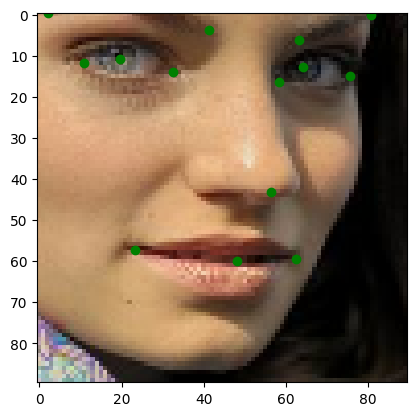

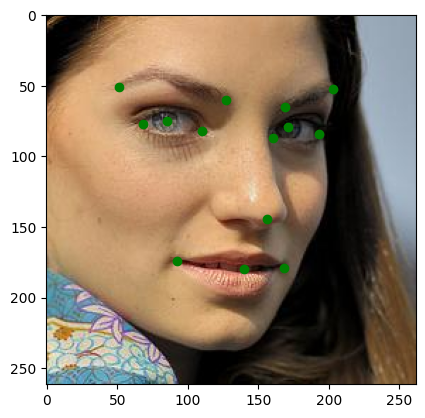

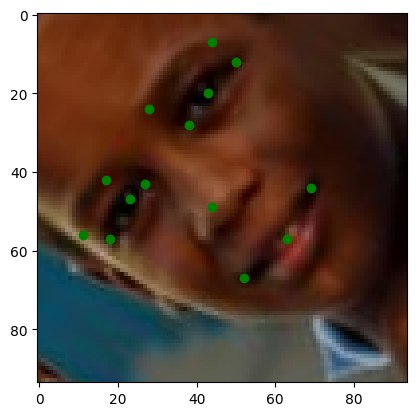

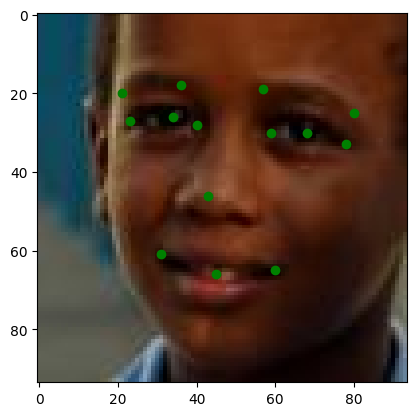

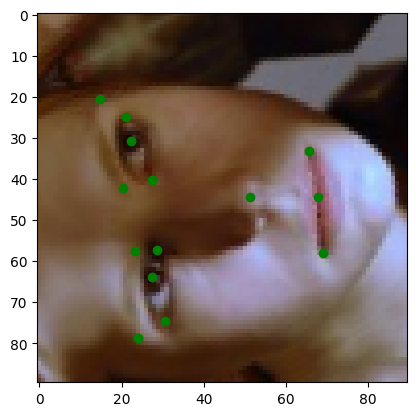

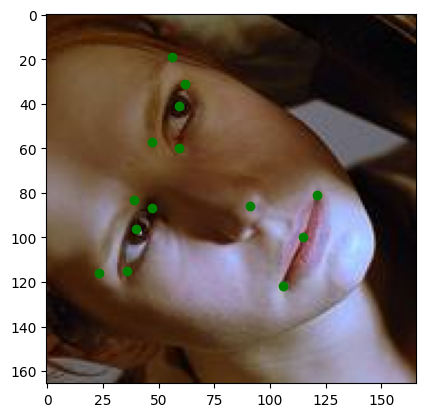

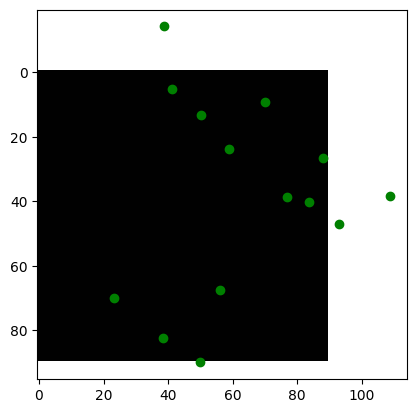

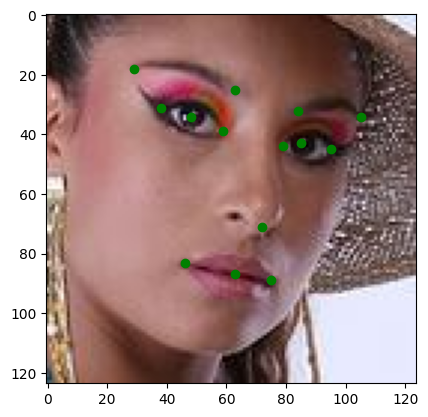

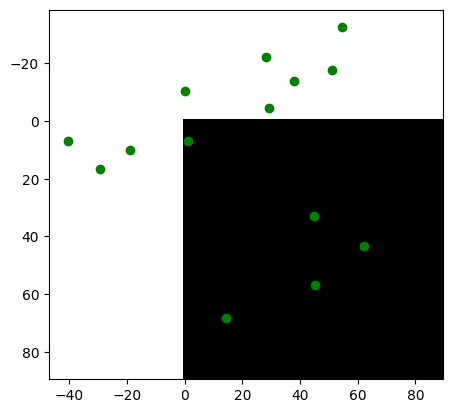

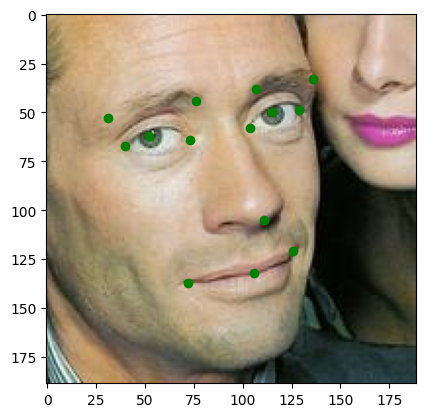

In [121]:
for i in range(5):
    filename,label = items[i]
    keypoints = get_label_xy_format(label)
    # print(keypoints)
    # print(label)
    image = get_img(filename)
    transformed = MyTransform(image=image.copy(), keypoints=keypoints)
    transformed_keypoints = get_label_original_format(torch.Tensor(transformed['keypoints']))
    vizualize(transformed['image'], transformed_keypoints, False, True)
    vizualize(image, label, False, True)